# ViT model median filter

In [ ]:
import tensorflow as tf

print(tf.__version__)

#version of tensorflow needs to be 2.15.0 to be able to work with the ViT package of keras

2.15.0


In [ ]:
%reset -f

In [ ]:
!pip install tensorflow==2.15.0

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from random import randint
import albumentations as A
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
#mount my drive

from google.colab import drive

drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
#load images into the local disc of Google Collab for faster image loading

!unzip "/content/drive/My Drive/Thesis/images_by_AR.zip" -d "/content"

In [ ]:
#load in the split datasets from the EDA section

#the undersampled, subsetted datasets

train = pd.read_csv('/content/drive/My Drive/Thesis/train_us.csv')
test_us = pd.read_csv('/content/drive/My Drive/Thesis/test_us.csv')
test_imb = pd.read_csv('/content/drive/My Drive/Thesis/test_imbalanced.csv')
val = pd.read_csv('/content/drive/My Drive/Thesis/val_us.csv')

print (len(train))
print (len(val))
print (len(test_us))
print (len(test_imb))

#numbers of the test set are not correct, they are fully tested in the results notebook 

74650
11243
9399
24175


## Making dataset with tf.data.Dataset

In [ ]:
#set up the augmentation pipeline
def augment (img):
  """Have the image augmented with random augmentation"""

  augmentations = A.Compose(
      [A.HorizontalFlip (p = 0.5),
       A.VerticalFlip(p=0.5),
       A.Rotate (limit=(-90,90), interpolation=cv.INTER_CUBIC, border_mode=cv.BORDER_REFLECT, p=0.5)]
  )

  augmented = augmentations(image=img)['image']

  return augmented

In [ ]:
#TRAIN SET
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import time

dir = '/content/images_by_AR/'

# Function to load and process images

def load_and_process_image(filename, label):
    # Decode the filename from bytes to string
    filename = filename.decode('utf-8')
    filename = os.path.join(dir, filename)
    # Read the image
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image at {filename} not found.")

    # Apply median filter
    img = cv2.medianBlur(img, 5)

    #run image through the augmentation pipeline
    img = augment(img)

    # Convert image from to RGB
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    img = img.astype(np.float32) / 255.0


    return img, label

# Create a tf.data.Dataset from the CSV
filenames = train['filename'].values
labels = train['class'].values

# Convert filenames and labels to TensorFlow Tensors
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# Map the loading and processing function
def map_func(filename, label):
    img, label = load_and_process_image(filename.numpy(), label.numpy())
    return img, label

# Apply tf.py_function and explicitly set output shapes
dataset = dataset.map(
    lambda filename, label: tf.py_function(
        func=map_func, inp=[filename, label], Tout=[tf.float32, tf.int64]
    ),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

def set_shapes(img, label):
    img.set_shape((224, 224, 3))  # Set the shape for the image
    label.set_shape(())  # Set the shape for the label (scalar)
    return img, label

dataset = dataset.map(set_shapes)

# Batch and prefetch the dataset for performance
dataset = dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

# Test the dataset for shape consistency
for images, labels in dataset.take(1):
    print ('batch fetched')


batch fetched


In [ ]:
for images, labels in dataset.take(1):  # Only take the first batch
    min_pixel = tf.reduce_min(images)
    max_pixel = tf.reduce_max(images)
    print("Pixel range in the batch:")
    print("Min pixel value:", min_pixel.numpy())
    print("Max pixel value:", max_pixel.numpy())

Pixel range in the batch:
Min pixel value: 0.050980393
Max pixel value: 0.99607843


In [ ]:
#VAL SET

import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import time

dir = '/content/images_by_AR/'

#loading in images and preprocess them
def load_and_process_image_val(filename, label):
    filename = filename.decode('utf-8')
    filename = os.path.join(dir, filename)
    #image loading
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image at {filename} not found.")

    # Apply median filter
    img = cv2.medianBlur(img, 5)

    # Convert image from to RGB
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    img = img.astype(np.float32) / 255.0


    return img, label

#convert these filenames and labels to np arrays to pass to the map (), because the preprocessing functions need np arrays and not tensors
def map_func_val(filename, label):
    img, label = load_and_process_image_val(filename.numpy(), label.numpy())
    return img, label

#get the filenames and labels to use in the functions created above
filenames_val = val['filename'].values
labels_val = val['class'].values

#make the datasets (turns filenames and labels to tensors)
val_dataset = tf.data.Dataset.from_tensor_slices((filenames_val, labels_val))

def process_image_and_label_val(filename, label):
    #apply the function
    img, label = tf.py_function(func=map_func_val, inp=[filename, label], Tout=[tf.float32, tf.int64])

    #set this shape because they get lost in the tf.py_function and otherwise the model cannot read the shapes
    img.set_shape([224, 224, 3])
    label.set_shape([])

    return img, label

#map the function to the dataset so everything is processed
val_dataset = val_dataset.map(process_image_and_label_val)

val_dataset = val_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
for batch in dataset.take(1):
    print("Batch input shape:", batch[0].shape)
    print("Batch target shape:", batch[1].shape)


Batch input shape: (64, 224, 224, 3)
Batch target shape: (64,)


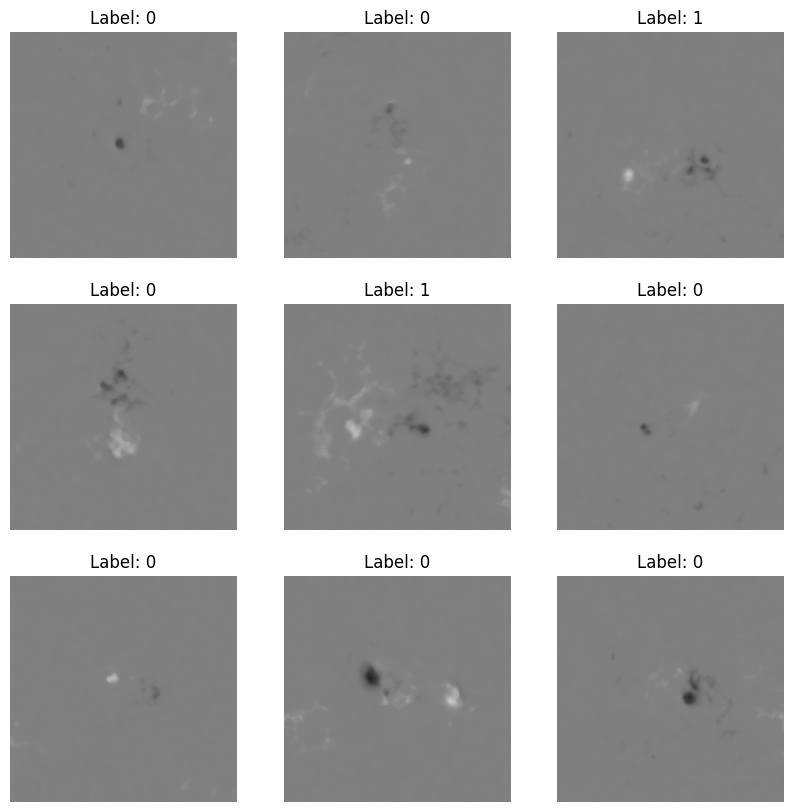

In [ ]:
import matplotlib.pyplot as plt

# Function to plot a grid of 9 images
def display_batch_of_images(images, labels):
    plt.figure(figsize=(10, 10))

    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")  # Hide axes

    plt.show()

# Fetch one batch of images and labels
for images, labels in dataset.take(1):
    # Since the dataset is batched, we take the first batch and display it
    display_batch_of_images(images, labels)
    break



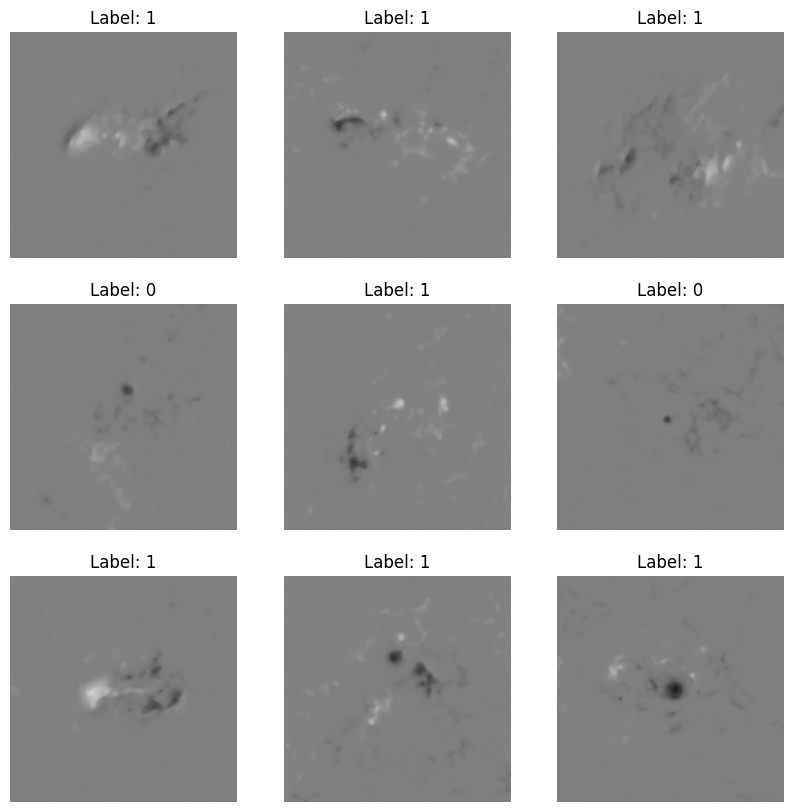

In [ ]:
for images, labels in val_dataset.take(1):
    # Since the dataset is batched, we take the first batch and display it
    display_batch_of_images(images, labels)
    break

## ViT loading

In [ ]:
!pip install vit-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.8 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.0
    Uninstalling typeguard-4.4.0:
      Successfully uninstalled typeguard-4.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
from vit_keras import vit

vit = vit.vit_b16(image_size=(224,224), activation="sigmoid", pretrained=True,
                            include_top=False, pretrained_top=False)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


347502902/347502902 [==============================] - 12s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [ ]:
#inspect vit

for layers in vit.layers:
  layers.trainable = False

vit.summary()

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input  (None, 197, 768)          151296    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 197, 768),        7087872   
  (TransformerBlock)          (None, 12, None, None)       

## Training model

In [ ]:
class_weights = {0: 1.0, 1: 1.2}

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras import layers, models, regularizers

for layer in vit.layers:
    layer.trainable = False

#unfreeze last layer
for layer in vit.layers[-2:]:
    layer.trainable = True

inputs = layers.Input(shape=(224, 224, 3))
x = vit(inputs)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  #add classification head
model = models.Model (inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 1)                 769       
                                                                 
Total params: 85799425 (327.30 MB)
Trainable params: 2305 (9.00 KB)
Non-trainable params: 85797120 (327.29 MB)
_________________________________________________________________


In [ ]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [ ]:
import keras
import tensorflow as tf

loss = tf.keras.losses.BinaryCrossentropy()

learning_rate_s = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.000001) #the lr was not reduced, so thus proved unnessecary

optimizer = tf.keras.optimizers.AdamW(learning_rate=0.00001, weight_decay = 0.001)

model.compile (optimizer=optimizer, loss=loss, metrics=['accuracy', precision, recall])

In [ ]:
#this model plateaued earlier (considering val accuracy and val recall) than 40 epochs, so to save GPU , model will be stopped early (20 epochs)

history = model.fit (dataset, validation_data = val_dataset, epochs = 40, class_weight = class_weights,
                     callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=15),
                        tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis/best_ViT.keras', save_best_only=True),
                        learning_rate_s
                    ], verbose = 1)

history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/My Drive/Thesis/history_ViT_med.csv')

Epoch 1/40
1167/1167 [==============================] - 1532s 1s/step - loss: 0.8635 - accuracy: 0.5352 - precision: 0.5369 - recall: 0.5127 - val_loss: 0.6603 - val_accuracy: 0.6268 - val_precision: 0.6121 - val_recall: 0.6923 - lr: 1.0000e-05
Epoch 2/40
1167/1167 [==============================] - 1502s 1s/step - loss: 0.7704 - accuracy: 0.5886 - precision: 0.5765 - recall: 0.6672 - val_loss: 0.6085 - val_accuracy: 0.6777 - val_precision: 0.6555 - val_recall: 0.7492 - lr: 1.0000e-05
Epoch 3/40
1167/1167 [==============================] - 1480s 1s/step - loss: 0.7205 - accuracy: 0.6298 - precision: 0.6134 - recall: 0.7019 - val_loss: 0.5822 - val_accuracy: 0.6972 - val_precision: 0.6753 - val_recall: 0.7600 - lr: 1.0000e-05
Epoch 4/40
1167/1167 [==============================] - 1478s 1s/step - loss: 0.6930 - accuracy: 0.6517 - precision: 0.6343 - recall: 0.7164 - val_loss: 0.5716 - val_accuracy: 0.7108 - val_precision: 0.6885 - val_recall: 0.7700 - lr: 1.0000e-05
Epoch 5/40
1167/1167

KeyboardInterrupt: 

## Save results for analysis

In [ ]:
from google.colab import drive

drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
#history was not saved due to interruption, so making it manually from the log

# Creating the dictionary of metrics
history_ViT_med = {
    'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
    'loss': [0.8635, 0.7704, 0.7205, 0.6930, 0.6741, 0.6623, 0.6516, 0.6425, 0.6390, 0.6368, 0.6314, 0.6284, 0.6240, 0.6222, 0.6217, 0.6180, 0.6165, 0.6137, 0.6114, 0.6109, 0.6109],
    'accuracy': [0.5352, 0.5886, 0.6298, 0.6517, 0.6675, 0.6767, 0.6868, 0.6919, 0.6930, 0.6958, 0.7012, 0.7038, 0.7061, 0.7058, 0.7076, 0.7091, 0.7107, 0.7113, 0.7136, 0.7148, 0.7152],
    'precision': [0.5369, 0.5765, 0.6134, 0.6343, 0.6487, 0.6588, 0.6685, 0.6736, 0.6752, 0.6781, 0.6834, 0.6868, 0.6891, 0.6885, 0.6902, 0.6922, 0.6938, 0.6939, 0.6968, 0.6980, 0.6989],
    'recall': [0.5127, 0.6672, 0.7019, 0.7164, 0.7308, 0.7329, 0.7414, 0.7445, 0.7440, 0.7456, 0.7496, 0.7494, 0.7509, 0.7515, 0.7534, 0.7531, 0.7545, 0.7562, 0.7564, 0.7571, 0.7561],
    'val_loss': [0.6603, 0.6085, 0.5822, 0.5716, 0.5645, 0.5657, 0.5636, 0.5577, 0.5543, 0.5555, 0.5500, 0.5484, 0.5471, 0.5449, 0.5457, 0.5451, 0.5430, 0.5434, 0.5430, 0.5410, 0.5412],
    'val_accuracy': [0.6268, 0.6777, 0.6972, 0.7108, 0.7152, 0.7124, 0.7156, 0.7187, 0.7189, 0.7199, 0.7226, 0.7288, 0.7248, 0.7266, 0.7259, 0.7276, 0.7297, 0.7310, 0.7310, 0.7306, 0.7333],
    'val_precision': [0.6121, 0.6555, 0.6753, 0.6885, 0.6924, 0.6907, 0.6952, 0.7007, 0.7018, 0.7052, 0.7105, 0.7178, 0.7186, 0.7199, 0.7205, 0.7260, 0.7281, 0.7305, 0.7352, 0.7336, 0.7398],
    'val_recall': [0.6923, 0.7492, 0.7600, 0.7700, 0.7745, 0.7695, 0.7681, 0.7634, 0.7615, 0.7558, 0.7513, 0.7542, 0.7391, 0.7419, 0.7382, 0.7311, 0.7334, 0.7323, 0.7223, 0.7243, 0.7197],
}


import pandas as pd

df = pd.DataFrame(history_ViT_med)

df.to_csv('/content/drive/My Drive/Thesis/history_ViT_med.csv')